In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime

In [37]:
def read_df_system(file, machine):
    # Read CSV data
    # Skip first row as it's useless
    # Only select the desired columns
    # Make sure #Date, Time columns are strings so we can easily parse them later
    df = pd.read_csv(file, skiprows = 1,
        usecols = ['#Date', 'Time', '[CPU]Totl%', '[MEM]Tot', '[MEM]Used', '[NET]RxKBTot', '[NET]TxKBTot'],
        dtype = {
            '#Date': str,
            'Time': str
        })

    # Build a time series with Timestamp objects from the #Date, Time columns
    timeseries = df[['#Date', 'Time']].apply(
        lambda s: pd.Timestamp(
            year = int(s[0][:4]),
            month = int(s[0][4:6]),
            day = int(s[0][6:]),
            hour = int(s[1].split(':')[0]),
            minute = int(s[1].split(':')[1]),
            second = int(s[1].split(':')[2])
        )
    , axis = 1)

    # Build a timedelta-based index
    test_start = timeseries.iloc[0]
    timeindex = timeseries.apply(lambda s: (s - test_start))

    df.index = pd.MultiIndex.from_product([[machine], timeindex], names = ['machine', 'time'])

    df.rename(columns = {
        '[CPU]Totl%': 'cpu_%',
        '[MEM]Tot': 'mem_total_kb',
        '[MEM]Used': 'mem_used_kb',
        '[NET]RxKBTot': 'net_recv_kb',
        '[NET]TxKBTot': 'net_send_kb'
    }, inplace = True)

    df.insert(4, 'mem_%', (df['mem_used_kb'] / df['mem_total_kb'] * 100).round().astype(int))

    df.drop(columns = ['#Date', 'Time', 'mem_total_kb', 'mem_used_kb'], inplace = True)

    return df

def read_dfs_system(app, storage, test_name, test_size):
    df = read_df_system(f'{app}/{storage}/{test_name}_{test_size}/cloud74_{test_name}_{test_size}_system.csv', 'cloud74')
    
    for i in range(75, 77):
        df2 = read_df_system(f'{app}/{storage}/{test_name}_{test_size}/cloud{i}_{test_name}_{test_size}_system.csv', f'cloud{i}')

        df = df.append(df2)
    
    return df

In [38]:
df = read_dfs_system('nextcloud', 'nfs', 'staticWrite', 100)
df


cpu_%  mem_%  net_recv_kb  net_send_kb
machine time                                                   
cloud74 0 days 00:00:00      8     92           44           84
        0 days 00:00:05      7     92           19           25
        0 days 00:00:10      6     92           41           65
        0 days 00:00:15      7     92           23           13
        0 days 00:00:20      7     92           83           55
...                        ...    ...          ...          ...
cloud76 0 days 00:16:35      9     97           34           30
        0 days 00:16:40      8     97           35           25
        0 days 00:16:45      8     97           28           24
        0 days 00:16:50     16     98          444          350
        0 days 00:16:55     11     97           31           39

[612 rows x 4 columns]

In [39]:
cpu_usage = df['cpu_%'].reset_index().pivot(index='time', columns = 'machine', values = ['cpu_%'])['cpu_%'].median(axis=1).rolling(2).mean().dropna()
cpu_usage

time
0 days 00:00:05    13.0
0 days 00:00:10    12.5
0 days 00:00:15    12.0
0 days 00:00:20    12.5
0 days 00:00:25    12.5
                   ... 
0 days 00:16:35     9.0
0 days 00:16:40     8.5
0 days 00:16:45     8.0
0 days 00:16:50     9.0
0 days 00:16:55    11.0
Length: 203, dtype: float64

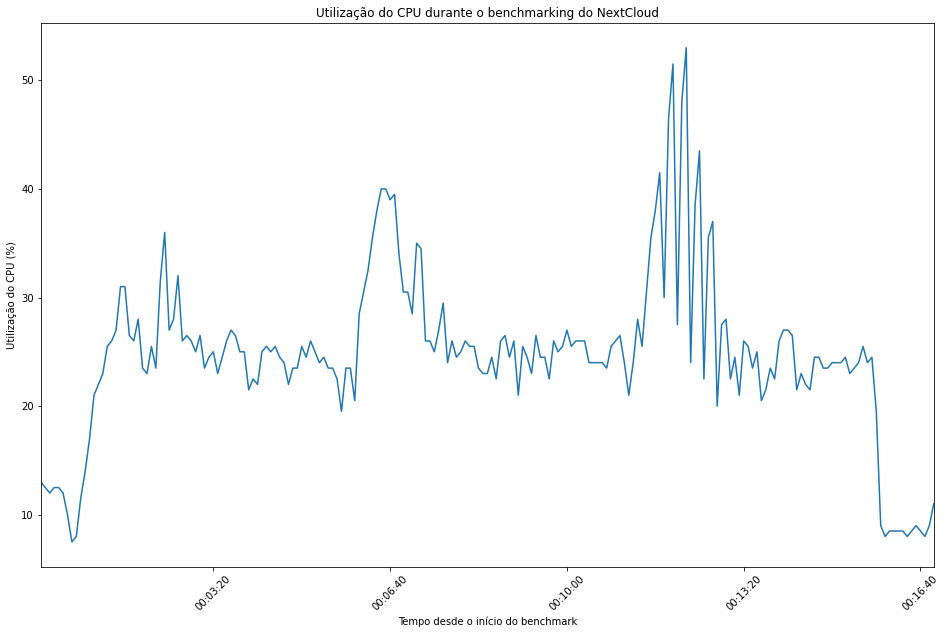

In [40]:
fig, ax = plt.subplots(figsize=(16, 10))

cpu_usage.plot(
    ax = ax,
    legend = False
)

ax.set_title('Utilização do CPU durante o benchmarking do NextCloud')

ax.set_xlabel('Tempo desde o início do benchmark')
ax.set_ylabel('Utilização do CPU (%)')

ax.tick_params(axis = 'x', labelrotation = 45)

# ax.legend(bbox_to_anchor=(1.1, 1))

plt.show()

In [41]:
def make_cpu_mem_graph(app, storage, test_name, test_size, graph_type = 'cpu', close = True):
    column_name = graph_type + '_%'

    fig, ax = plt.subplots(figsize=(16, 10))
    
    df = read_dfs_system(app, storage, test_name, test_size)[[column_name]]

    usage = df.reset_index() \
        .pivot(index='time', columns = 'machine', values = [f'{column_name}'])[f'{column_name}'] \
        .median(axis=1) \
        .rolling(2).mean().dropna()

    usage.plot(
        ax = ax,
        legend = False,
        color = 'blue' if graph_type == 'cpu' else 'red'
    )

    graph_label = "do CPU" if graph_type == "cpu" else "da RAM"

    ax.set_title(f'Utilização mediana {graph_label} pelas três máquinas durante o benchmarking do {app} (rolling avg. 15s, teste de {test_name.replace("static", "")}, backend {storage}, {test_size} utilizadores)')

    ax.set_xlabel('Tempo desde o início do benchmark (HH:MM:SS)')
    ax.set_ylabel(f'Utilização {graph_label} (%)')

    ax.tick_params(axis = 'x', labelrotation = 45)

    fig.savefig(f'{app.lower()}/{storage.lower()}/{test_name}_{test_size}/{test_name}_{test_size}_{graph_type}.png')
    # plt.show()

    if close:
        plt.close(fig)

In [42]:
def make_graphs_for_scenario(app, storage, test_name, test_size):
    make_cpu_mem_graph(app, storage, test_name, test_size, 'cpu')
    make_cpu_mem_graph(app, storage, test_name, test_size, 'mem')
    # Faltam os gráficos da network

In [43]:
def make_graphs():
    for app in ['Wiki', 'NextCloud']: # Falta Peertube
        for storage in ['NFS']: # Falta Ceph
            for test_name in ['staticRead', 'staticWrite', 'simulateUser']:
                for test_size in [25, 50, 75, 100]:
                    make_graphs_for_scenario(app, storage, test_name, test_size)

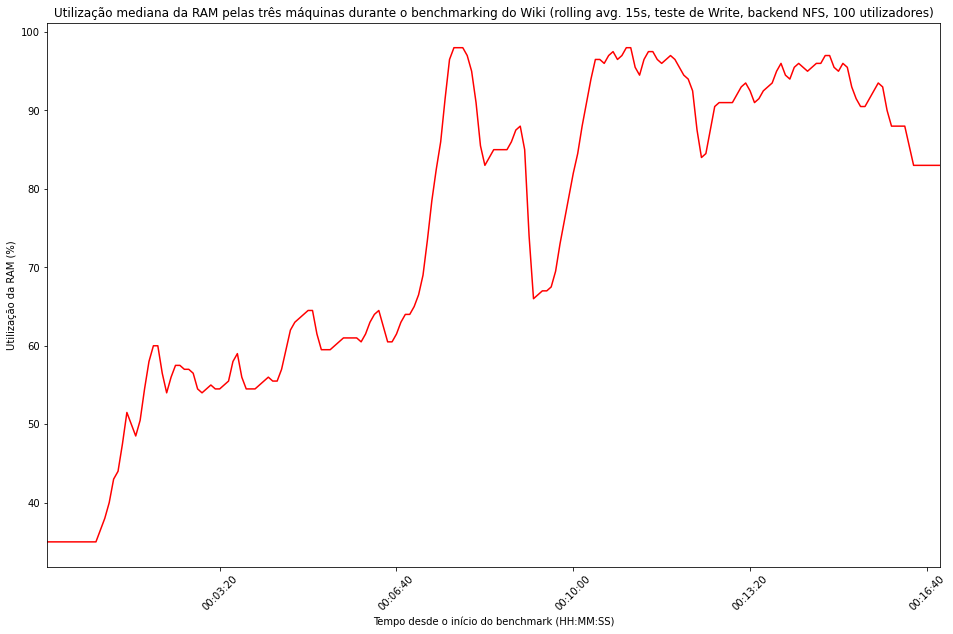

In [44]:
make_cpu_mem_graph('Wiki', 'NFS', 'staticWrite', 100, 'mem', False)

In [45]:
make_graphs()

In [46]:
plt.close('all')

In [47]:
df = pd.read_csv('wiki/nfs/staticWrite_100/locust_staticWrite_100_stats_history.csv')
df

,Timestamp,User Count,Type,Name,Requests/s,Failures/s,50%,66%,75%,80%,...,99.9%,99.99%,100%,Total Request Count,Total Failure Count,Total Median Response Time,Total Average Response Time,Total Min Response Time,Total Max Response Time,Total Average Content Size
0,1622121487,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000
1,1622121488,0,NaN,Aggregated,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000
2,1622121489,2,NaN,Aggregated,0.0,0.0,91.0,130.0,490.0,490.0,...,860.0,860.0,860.0,12,0,87.0,240.675987,13.338525,864.053981,119.166667
3,1622121490,6,NaN,Aggregated,0.0,0.0,71.0,91.0,130.0,310.0,...,860.0,860.0,860.0,43,0,71.0,153.759904,9.493664,864.053981,116.372093
4,1622121491,6,NaN,Aggregated,0.0,0.0,71.0,91.0,130.0,310.0,...,860.0,860.0,860.0,43,0,71.0,153.759904,9.493664,864.053981,116.372093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1622122385,100,NaN,Aggregated,17.1,1.4,560.0,1300.0,2200.0,2800.0,...,77000.0,89000.0,90000.0,19371,742,560.0,2735.904472,2.314339,89936.246359,5069.950080
887,1622122386,100,NaN,Aggregated,17.1,1.4,560.0,1300.0,2200.0,2800.0,...,77000.0,89000.0,90000.0,19371,742,560.0,2735.904472,2.314339,89936.246359,5069.950080
888,1622122387,100,NaN,Aggregated,16.1,1.2,560.0,1300.0,2200.0,2900.0,...,77000.0,89000.0,90000.0,19410,744,560.0,2737.927743,2.314339,89936.246359,5081.716229
889,1622122388,0,NaN,Aggregated,16.1,1.2,560.0,1300.0,2200.0,2900.0,...,77000.0,89000.0,90000.0,19477,746,560.0,2734.452136,2.314339,89936.246359,5108.045130


In [48]:
import json
data = json.loads("{\"time\":[\"14:18:07\",\"14:18:12\",\"14:18:17\",\"14:18:22\",\"14:18:27\",\"14:18:32\",\"14:18:37\",\"14:18:42\",\"14:18:47\",\"14:18:52\",\"14:18:57\",\"14:19:02\",\"14:19:07\",\"14:19:12\",\"14:19:17\",\"14:19:22\",\"14:19:27\",\"14:19:32\",\"14:19:37\",\"14:19:42\",\"14:19:47\",\"14:19:52\",\"14:19:57\",\"14:20:02\",\"14:20:07\",\"14:20:12\",\"14:20:17\",\"14:20:22\",\"14:20:27\",\"14:20:32\",\"14:20:37\",\"14:20:42\",\"14:20:47\",\"14:20:52\",\"14:20:57\",\"14:21:02\",\"14:21:07\",\"14:21:12\",\"14:21:17\",\"14:21:22\",\"14:21:27\",\"14:21:32\",\"14:21:37\",\"14:21:42\",\"14:21:47\",\"14:21:52\",\"14:21:57\",\"14:22:02\",\"14:22:07\",\"14:22:12\",\"14:22:17\",\"14:22:22\",\"14:22:27\",\"14:22:32\",\"14:22:37\",\"14:22:42\",\"14:22:47\",\"14:22:52\",\"14:22:57\",\"14:23:02\",\"14:23:07\",\"14:23:12\",\"14:23:17\",\"14:23:22\",\"14:23:27\",\"14:23:32\",\"14:23:37\",\"14:23:42\",\"14:23:47\",\"14:23:52\",\"14:23:57\",\"14:24:02\",\"14:24:07\",\"14:24:12\",\"14:24:17\",\"14:24:22\",\"14:24:27\",\"14:24:32\",\"14:24:37\",\"14:24:42\",\"14:24:47\",\"14:24:52\",\"14:24:57\",\"14:25:02\",\"14:25:07\",\"14:25:12\",\"14:25:17\",\"14:25:22\",\"14:25:27\",\"14:25:32\",\"14:25:37\",\"14:25:42\",\"14:25:47\",\"14:25:52\",\"14:25:57\",\"14:26:02\",\"14:26:07\",\"14:26:12\",\"14:26:17\",\"14:26:22\",\"14:26:27\",\"14:26:32\",\"14:26:37\",\"14:26:42\",\"14:26:47\",\"14:26:52\",\"14:26:57\",\"14:27:02\",\"14:27:07\",\"14:27:12\",\"14:27:17\",\"14:27:22\",\"14:27:27\",\"14:27:32\",\"14:27:37\",\"14:27:43\",\"14:27:48\",\"14:27:53\",\"14:27:58\",\"14:28:03\",\"14:28:08\",\"14:28:13\",\"14:28:18\",\"14:28:23\",\"14:28:28\",\"14:28:33\",\"14:28:38\",\"14:28:43\",\"14:28:48\",\"14:28:53\",\"14:28:58\",\"14:29:03\",\"14:29:08\",\"14:29:13\",\"14:29:18\",\"14:29:23\",\"14:29:28\",\"14:29:33\",\"14:29:38\",\"14:29:43\",\"14:29:48\",\"14:29:53\",\"14:29:58\",\"14:30:03\",\"14:30:08\",\"14:30:13\",\"14:30:18\",\"14:30:23\",\"14:30:28\",\"14:30:33\",\"14:30:38\",\"14:30:43\",\"14:30:48\",\"14:30:53\",\"14:30:58\",\"14:31:03\",\"14:31:08\",\"14:31:13\",\"14:31:18\",\"14:31:23\",\"14:31:28\",\"14:31:33\",\"14:31:38\",\"14:31:43\",\"14:31:48\",\"14:31:53\",\"14:31:58\",\"14:32:03\",\"14:32:08\",\"14:32:13\",\"14:32:18\",\"14:32:23\",\"14:32:28\",\"14:32:33\",\"14:32:38\",\"14:32:43\",\"14:32:48\",\"14:32:53\",\"14:32:58\",\"14:33:03\"],\"user_count\":[{\"value\":0},{\"value\":10},{\"value\":18},{\"value\":30},{\"value\":38},{\"value\":48},{\"value\":60},{\"value\":70},{\"value\":78},{\"value\":90},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100},{\"value\":100}],\"current_rps\":[{\"users\":0,\"value\":0},{\"users\":10,\"value\":20},{\"users\":18,\"value\":18.833333333333332},{\"users\":30,\"value\":22.3},{\"users\":38,\"value\":24},{\"users\":48,\"value\":24.1},{\"users\":60,\"value\":22.2},{\"users\":70,\"value\":23.7},{\"users\":78,\"value\":25.5},{\"users\":90,\"value\":28.2},{\"users\":100,\"value\":27},{\"users\":100,\"value\":24.9},{\"users\":100,\"value\":26.5},{\"users\":100,\"value\":32.7},{\"users\":100,\"value\":31.1},{\"users\":100,\"value\":21.3},{\"users\":100,\"value\":15.4},{\"users\":100,\"value\":14.3},{\"users\":100,\"value\":14.9},{\"users\":100,\"value\":16.2},{\"users\":100,\"value\":18},{\"users\":100,\"value\":13.7},{\"users\":100,\"value\":12.5},{\"users\":100,\"value\":15.8},{\"users\":100,\"value\":18.4},{\"users\":100,\"value\":20.2},{\"users\":100,\"value\":17.9},{\"users\":100,\"value\":10.4},{\"users\":100,\"value\":11},{\"users\":100,\"value\":12.6},{\"users\":100,\"value\":14.1},{\"users\":100,\"value\":16.7},{\"users\":100,\"value\":21.1},{\"users\":100,\"value\":24.6},{\"users\":100,\"value\":27.1},{\"users\":100,\"value\":25.6},{\"users\":100,\"value\":16.5},{\"users\":100,\"value\":17},{\"users\":100,\"value\":17.4},{\"users\":100,\"value\":15.7},{\"users\":100,\"value\":20.4},{\"users\":100,\"value\":19.4},{\"users\":100,\"value\":15.6},{\"users\":100,\"value\":13.5},{\"users\":100,\"value\":17},{\"users\":100,\"value\":20.7},{\"users\":100,\"value\":22.2},{\"users\":100,\"value\":25.5},{\"users\":100,\"value\":23.2},{\"users\":100,\"value\":18.5},{\"users\":100,\"value\":18.1},{\"users\":100,\"value\":23.9},{\"users\":100,\"value\":24.2},{\"users\":100,\"value\":25.2},{\"users\":100,\"value\":23.5},{\"users\":100,\"value\":24.6},{\"users\":100,\"value\":25.9},{\"users\":100,\"value\":25.5},{\"users\":100,\"value\":17.9},{\"users\":100,\"value\":20.6},{\"users\":100,\"value\":17},{\"users\":100,\"value\":17.5},{\"users\":100,\"value\":22.5},{\"users\":100,\"value\":22},{\"users\":100,\"value\":24},{\"users\":100,\"value\":28.7},{\"users\":100,\"value\":30.8},{\"users\":100,\"value\":30.5},{\"users\":100,\"value\":33.4},{\"users\":100,\"value\":26.5},{\"users\":100,\"value\":19.1},{\"users\":100,\"value\":22.2},{\"users\":100,\"value\":23.9},{\"users\":100,\"value\":23.6},{\"users\":100,\"value\":19.7},{\"users\":100,\"value\":16.9},{\"users\":100,\"value\":18.7},{\"users\":100,\"value\":21},{\"users\":100,\"value\":20.3},{\"users\":100,\"value\":20.9},{\"users\":100,\"value\":26.2},{\"users\":100,\"value\":24.4},{\"users\":100,\"value\":23},{\"users\":100,\"value\":21.4},{\"users\":100,\"value\":22},{\"users\":100,\"value\":24.7},{\"users\":100,\"value\":23.4},{\"users\":100,\"value\":22},{\"users\":100,\"value\":21.7},{\"users\":100,\"value\":21.6},{\"users\":100,\"value\":24.1},{\"users\":100,\"value\":23},{\"users\":100,\"value\":21.2},{\"users\":100,\"value\":20.9},{\"users\":100,\"value\":22.9},{\"users\":100,\"value\":18.4},{\"users\":100,\"value\":15.1},{\"users\":100,\"value\":18.6},{\"users\":100,\"value\":20.2},{\"users\":100,\"value\":22.8},{\"users\":100,\"value\":27.2},{\"users\":100,\"value\":27.5},{\"users\":100,\"value\":28.2},{\"users\":100,\"value\":25.2},{\"users\":100,\"value\":26},{\"users\":100,\"value\":29.8},{\"users\":100,\"value\":23.6},{\"users\":100,\"value\":21.2},{\"users\":100,\"value\":20.8},{\"users\":100,\"value\":17.5},{\"users\":100,\"value\":16.1},{\"users\":100,\"value\":15.6},{\"users\":100,\"value\":16.3},{\"users\":100,\"value\":16.7},{\"users\":100,\"value\":22.8},{\"users\":100,\"value\":26.2},{\"users\":100,\"value\":29},{\"users\":100,\"value\":27.7},{\"users\":100,\"value\":18.7},{\"users\":100,\"value\":16},{\"users\":100,\"value\":19.6},{\"users\":100,\"value\":22},{\"users\":100,\"value\":20.1},{\"users\":100,\"value\":13.5},{\"users\":100,\"value\":15.4},{\"users\":100,\"value\":16.8},{\"users\":100,\"value\":24.3},{\"users\":100,\"value\":28.2},{\"users\":100,\"value\":20.3},{\"users\":100,\"value\":21.2},{\"users\":100,\"value\":22},{\"users\":100,\"value\":19},{\"users\":100,\"value\":14.7},{\"users\":100,\"value\":22.9},{\"users\":100,\"value\":30.1},{\"users\":100,\"value\":29.1},{\"users\":100,\"value\":24.9},{\"users\":100,\"value\":24.8},{\"users\":100,\"value\":21.9},{\"users\":100,\"value\":18.7},{\"users\":100,\"value\":16.5},{\"users\":100,\"value\":8.8},{\"users\":100,\"value\":23.2},{\"users\":100,\"value\":32.9},{\"users\":100,\"value\":26.6},{\"users\":100,\"value\":14.8},{\"users\":100,\"value\":12.5},{\"users\":100,\"value\":20},{\"users\":100,\"value\":32.7},{\"users\":100,\"value\":35},{\"users\":100,\"value\":34.6},{\"users\":100,\"value\":24.5},{\"users\":100,\"value\":15.3},{\"users\":100,\"value\":14.7},{\"users\":100,\"value\":15.8},{\"users\":100,\"value\":17.3},{\"users\":100,\"value\":17.5},{\"users\":100,\"value\":20.6},{\"users\":100,\"value\":21.8},{\"users\":100,\"value\":21.1},{\"users\":100,\"value\":25.2},{\"users\":100,\"value\":28.8},{\"users\":100,\"value\":28.5},{\"users\":100,\"value\":21.5},{\"users\":100,\"value\":15.5},{\"users\":100,\"value\":17.7},{\"users\":100,\"value\":20.9},{\"users\":100,\"value\":21.8},{\"users\":100,\"value\":22},{\"users\":100,\"value\":21.8},{\"users\":100,\"value\":21.3},{\"users\":100,\"value\":24.9},{\"users\":100,\"value\":30.2},{\"users\":100,\"value\":27.6},{\"users\":100,\"value\":18.5},{\"users\":100,\"value\":20},{\"users\":100,\"value\":26.9},{\"users\":100,\"value\":26.2},{\"users\":100,\"value\":23.2},{\"users\":100,\"value\":18.5}],\"current_fail_per_sec\":[{\"users\":0,\"value\":0},{\"users\":10,\"value\":0},{\"users\":18,\"value\":0},{\"users\":30,\"value\":0},{\"users\":38,\"value\":0},{\"users\":48,\"value\":0},{\"users\":60,\"value\":0},{\"users\":70,\"value\":0},{\"users\":78,\"value\":0},{\"users\":90,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0.2},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.2},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.2},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.2},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0.2},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":2.2},{\"users\":100,\"value\":1.8},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":1.6},{\"users\":100,\"value\":1.6},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":1.4},{\"users\":100,\"value\":1.6},{\"users\":100,\"value\":2},{\"users\":100,\"value\":2.2},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1.6},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1.4},{\"users\":100,\"value\":1.4},{\"users\":100,\"value\":1.4},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":2.2},{\"users\":100,\"value\":3},{\"users\":100,\"value\":2.4},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1.4},{\"users\":100,\"value\":1.4},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.3},{\"users\":100,\"value\":1.1},{\"users\":100,\"value\":1.1},{\"users\":100,\"value\":0.2},{\"users\":100,\"value\":0},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":1.8},{\"users\":100,\"value\":1.6},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1.4},{\"users\":100,\"value\":1.4},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.2},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":1.6},{\"users\":100,\"value\":1.8},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":2.4},{\"users\":100,\"value\":2.2},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.2},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":1.4},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.2},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":1.4},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.2},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.4},{\"users\":100,\"value\":0.8},{\"users\":100,\"value\":0.6},{\"users\":100,\"value\":1},{\"users\":100,\"value\":1.2},{\"users\":100,\"value\":1.8},{\"users\":100,\"value\":1.6}],\"response_time_percentile_50\":[{\"users\":0,\"value\":0},{\"users\":10,\"value\":55},{\"users\":18,\"value\":99},{\"users\":30,\"value\":160},{\"users\":38,\"value\":250},{\"users\":48,\"value\":300},{\"users\":60,\"value\":390},{\"users\":70,\"value\":530},{\"users\":78,\"value\":580},{\"users\":90,\"value\":760},{\"users\":100,\"value\":1200},{\"users\":100,\"value\":1800},{\"users\":100,\"value\":2000},{\"users\":100,\"value\":1800},{\"users\":100,\"value\":1400},{\"users\":100,\"value\":1900},{\"users\":100,\"value\":2200},{\"users\":100,\"value\":1400},{\"users\":100,\"value\":1200},{\"users\":100,\"value\":970},{\"users\":100,\"value\":650},{\"users\":100,\"value\":400},{\"users\":100,\"value\":1000},{\"users\":100,\"value\":810},{\"users\":100,\"value\":620},{\"users\":100,\"value\":400},{\"users\":100,\"value\":290},{\"users\":100,\"value\":720},{\"users\":100,\"value\":870},{\"users\":100,\"value\":880},{\"users\":100,\"value\":2000},{\"users\":100,\"value\":2800},{\"users\":100,\"value\":2300},{\"users\":100,\"value\":940},{\"users\":100,\"value\":550},{\"users\":100,\"value\":610},{\"users\":100,\"value\":2200},{\"users\":100,\"value\":590},{\"users\":100,\"value\":210},{\"users\":100,\"value\":120},{\"users\":100,\"value\":210},{\"users\":100,\"value\":390},{\"users\":100,\"value\":860},{\"users\":100,\"value\":1600},{\"users\":100,\"value\":1000},{\"users\":100,\"value\":1000},{\"users\":100,\"value\":930},{\"users\":100,\"value\":670},{\"users\":100,\"value\":650},{\"users\":100,\"value\":640},{\"users\":100,\"value\":500},{\"users\":100,\"value\":270},{\"users\":100,\"value\":180},{\"users\":100,\"value\":230},{\"users\":100,\"value\":200},{\"users\":100,\"value\":220},{\"users\":100,\"value\":290},{\"users\":100,\"value\":280},{\"users\":100,\"value\":320},{\"users\":100,\"value\":340},{\"users\":100,\"value\":430},{\"users\":100,\"value\":1500},{\"users\":100,\"value\":970},{\"users\":100,\"value\":1200},{\"users\":100,\"value\":600},{\"users\":100,\"value\":630},{\"users\":100,\"value\":710},{\"users\":100,\"value\":580},{\"users\":100,\"value\":320},{\"users\":100,\"value\":310},{\"users\":100,\"value\":350},{\"users\":100,\"value\":310},{\"users\":100,\"value\":290},{\"users\":100,\"value\":420},{\"users\":100,\"value\":510},{\"users\":100,\"value\":550},{\"users\":100,\"value\":820},{\"users\":100,\"value\":970},{\"users\":100,\"value\":750},{\"users\":100,\"value\":650},{\"users\":100,\"value\":630},{\"users\":100,\"value\":640},{\"users\":100,\"value\":520},{\"users\":100,\"value\":480},{\"users\":100,\"value\":420},{\"users\":100,\"value\":290},{\"users\":100,\"value\":340},{\"users\":100,\"value\":330},{\"users\":100,\"value\":260},{\"users\":100,\"value\":160},{\"users\":100,\"value\":140},{\"users\":100,\"value\":140},{\"users\":100,\"value\":100},{\"users\":100,\"value\":97},{\"users\":100,\"value\":180},{\"users\":100,\"value\":440},{\"users\":100,\"value\":2300},{\"users\":100,\"value\":2100},{\"users\":100,\"value\":1200},{\"users\":100,\"value\":2000},{\"users\":100,\"value\":690},{\"users\":100,\"value\":770},{\"users\":100,\"value\":960},{\"users\":100,\"value\":950},{\"users\":100,\"value\":720},{\"users\":100,\"value\":570},{\"users\":100,\"value\":660},{\"users\":100,\"value\":660},{\"users\":100,\"value\":550},{\"users\":100,\"value\":530},{\"users\":100,\"value\":580},{\"users\":100,\"value\":770},{\"users\":100,\"value\":770},{\"users\":100,\"value\":1400},{\"users\":100,\"value\":1700},{\"users\":100,\"value\":700},{\"users\":100,\"value\":510},{\"users\":100,\"value\":400},{\"users\":100,\"value\":400},{\"users\":100,\"value\":480},{\"users\":100,\"value\":330},{\"users\":100,\"value\":290},{\"users\":100,\"value\":360},{\"users\":100,\"value\":1400},{\"users\":100,\"value\":1900},{\"users\":100,\"value\":1700},{\"users\":100,\"value\":750},{\"users\":100,\"value\":720},{\"users\":100,\"value\":820},{\"users\":100,\"value\":570},{\"users\":100,\"value\":550},{\"users\":100,\"value\":750},{\"users\":100,\"value\":1200},{\"users\":100,\"value\":670},{\"users\":100,\"value\":560},{\"users\":100,\"value\":520},{\"users\":100,\"value\":450},{\"users\":100,\"value\":310},{\"users\":100,\"value\":170},{\"users\":100,\"value\":140},{\"users\":100,\"value\":33},{\"users\":100,\"value\":330},{\"users\":100,\"value\":430},{\"users\":100,\"value\":450},{\"users\":100,\"value\":660},{\"users\":100,\"value\":1100},{\"users\":100,\"value\":2000},{\"users\":100,\"value\":1200},{\"users\":100,\"value\":820},{\"users\":100,\"value\":810},{\"users\":100,\"value\":680},{\"users\":100,\"value\":670},{\"users\":100,\"value\":710},{\"users\":100,\"value\":540},{\"users\":100,\"value\":540},{\"users\":100,\"value\":560},{\"users\":100,\"value\":610},{\"users\":100,\"value\":560},{\"users\":100,\"value\":810},{\"users\":100,\"value\":1100},{\"users\":100,\"value\":700},{\"users\":100,\"value\":600},{\"users\":100,\"value\":580},{\"users\":100,\"value\":470},{\"users\":100,\"value\":530},{\"users\":100,\"value\":630},{\"users\":100,\"value\":490},{\"users\":100,\"value\":590},{\"users\":100,\"value\":770},{\"users\":100,\"value\":780},{\"users\":100,\"value\":1000},{\"users\":100,\"value\":780},{\"users\":100,\"value\":420},{\"users\":100,\"value\":330},{\"users\":100,\"value\":360},{\"users\":100,\"value\":380},{\"users\":100,\"value\":350},{\"users\":100,\"value\":380},{\"users\":100,\"value\":420},{\"users\":100,\"value\":500}],\"response_time_percentile_95\":[{\"users\":0,\"value\":0},{\"users\":10,\"value\":640},{\"users\":18,\"value\":1200},{\"users\":30,\"value\":1600},{\"users\":38,\"value\":2100},{\"users\":48,\"value\":2500},{\"users\":60,\"value\":7000},{\"users\":70,\"value\":7000},{\"users\":78,\"value\":7800},{\"users\":90,\"value\":7100},{\"users\":100,\"value\":5300},{\"users\":100,\"value\":7100},{\"users\":100,\"value\":15000},{\"users\":100,\"value\":14000},{\"users\":100,\"value\":5600},{\"users\":100,\"value\":7600},{\"users\":100,\"value\":16000},{\"users\":100,\"value\":14000},{\"users\":100,\"value\":23000},{\"users\":100,\"value\":25000},{\"users\":100,\"value\":24000},{\"users\":100,\"value\":21000},{\"users\":100,\"value\":24000},{\"users\":100,\"value\":23000},{\"users\":100,\"value\":21000},{\"users\":100,\"value\":28000},{\"users\":100,\"value\":28000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":14000},{\"users\":100,\"value\":24000},{\"users\":100,\"value\":25000},{\"users\":100,\"value\":10000},{\"users\":100,\"value\":7500},{\"users\":100,\"value\":10000},{\"users\":100,\"value\":9600},{\"users\":100,\"value\":35000},{\"users\":100,\"value\":65000},{\"users\":100,\"value\":26000},{\"users\":100,\"value\":4000},{\"users\":100,\"value\":1700},{\"users\":100,\"value\":3600},{\"users\":100,\"value\":7000},{\"users\":100,\"value\":11000},{\"users\":100,\"value\":13000},{\"users\":100,\"value\":13000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":14000},{\"users\":100,\"value\":19000},{\"users\":100,\"value\":26000},{\"users\":100,\"value\":5300},{\"users\":100,\"value\":27000},{\"users\":100,\"value\":35000},{\"users\":100,\"value\":34000},{\"users\":100,\"value\":18000},{\"users\":100,\"value\":13000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":6200},{\"users\":100,\"value\":9000},{\"users\":100,\"value\":14000},{\"users\":100,\"value\":14000},{\"users\":100,\"value\":14000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":11000},{\"users\":100,\"value\":6800},{\"users\":100,\"value\":5300},{\"users\":100,\"value\":4900},{\"users\":100,\"value\":22000},{\"users\":100,\"value\":13000},{\"users\":100,\"value\":3000},{\"users\":100,\"value\":5300},{\"users\":100,\"value\":6100},{\"users\":100,\"value\":8000},{\"users\":100,\"value\":10000},{\"users\":100,\"value\":16000},{\"users\":100,\"value\":16000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":9300},{\"users\":100,\"value\":4600},{\"users\":100,\"value\":4800},{\"users\":100,\"value\":4200},{\"users\":100,\"value\":4200},{\"users\":100,\"value\":3000},{\"users\":100,\"value\":2500},{\"users\":100,\"value\":3200},{\"users\":100,\"value\":3500},{\"users\":100,\"value\":51000},{\"users\":100,\"value\":51000},{\"users\":100,\"value\":29000},{\"users\":100,\"value\":14000},{\"users\":100,\"value\":4300},{\"users\":100,\"value\":3500},{\"users\":100,\"value\":5100},{\"users\":100,\"value\":11000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":14000},{\"users\":100,\"value\":13000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":13000},{\"users\":100,\"value\":10000},{\"users\":100,\"value\":7100},{\"users\":100,\"value\":5900},{\"users\":100,\"value\":7300},{\"users\":100,\"value\":7600},{\"users\":100,\"value\":9400},{\"users\":100,\"value\":11000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":13000},{\"users\":100,\"value\":15000},{\"users\":100,\"value\":13000},{\"users\":100,\"value\":10000},{\"users\":100,\"value\":7900},{\"users\":100,\"value\":4600},{\"users\":100,\"value\":44000},{\"users\":100,\"value\":42000},{\"users\":100,\"value\":21000},{\"users\":100,\"value\":3800},{\"users\":100,\"value\":21000},{\"users\":100,\"value\":22000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":13000},{\"users\":100,\"value\":34000},{\"users\":100,\"value\":28000},{\"users\":100,\"value\":8100},{\"users\":100,\"value\":6000},{\"users\":100,\"value\":5000},{\"users\":100,\"value\":7200},{\"users\":100,\"value\":8500},{\"users\":100,\"value\":24000},{\"users\":100,\"value\":8900},{\"users\":100,\"value\":5600},{\"users\":100,\"value\":7300},{\"users\":100,\"value\":28000},{\"users\":100,\"value\":28000},{\"users\":100,\"value\":31000},{\"users\":100,\"value\":27000},{\"users\":100,\"value\":22000},{\"users\":100,\"value\":11000},{\"users\":100,\"value\":9100},{\"users\":100,\"value\":4400},{\"users\":100,\"value\":7200},{\"users\":100,\"value\":11000},{\"users\":100,\"value\":17000},{\"users\":100,\"value\":19000},{\"users\":100,\"value\":15000},{\"users\":100,\"value\":8800},{\"users\":100,\"value\":14000},{\"users\":100,\"value\":15000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":11000},{\"users\":100,\"value\":8500},{\"users\":100,\"value\":11000},{\"users\":100,\"value\":12000},{\"users\":100,\"value\":11000},{\"users\":100,\"value\":11000},{\"users\":100,\"value\":13000},{\"users\":100,\"value\":9000},{\"users\":100,\"value\":6800},{\"users\":100,\"value\":6900},{\"users\":100,\"value\":27000},{\"users\":100,\"value\":32000},{\"users\":100,\"value\":23000},{\"users\":100,\"value\":6300},{\"users\":100,\"value\":5900},{\"users\":100,\"value\":6200},{\"users\":100,\"value\":7400},{\"users\":100,\"value\":9100},{\"users\":100,\"value\":7400},{\"users\":100,\"value\":3500},{\"users\":100,\"value\":34000},{\"users\":100,\"value\":37000},{\"users\":100,\"value\":25000},{\"users\":100,\"value\":16000},{\"users\":100,\"value\":9200},{\"users\":100,\"value\":5200},{\"users\":100,\"value\":7300}]}")

In [49]:
df2 = pd.DataFrame(data)
for column in df2.columns[1:]:
    df2[column] = df2[column].apply(lambda x: x['value'])

In [50]:
df2

,time,user_count,current_rps,current_fail_per_sec,response_time_percentile_50,response_time_percentile_95
0,14:18:07,0,0.000000,0.0,0,0
1,14:18:12,10,20.000000,0.0,55,640
2,14:18:17,18,18.833333,0.0,99,1200
3,14:18:22,30,22.300000,0.0,160,1600
4,14:18:27,38,24.000000,0.0,250,2100
...,...,...,...,...,...,...
175,14:32:43,100,20.000000,0.6,380,25000
176,14:32:48,100,26.900000,1.0,350,16000
177,14:32:53,100,26.200000,1.2,380,9200
178,14:32:58,100,23.200000,1.8,420,5200


<AxesSubplot:>

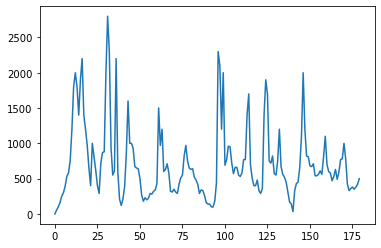

In [51]:
df2['response_time_percentile_50'].plot()

In [52]:
df2[['response_time_percentile_50']]

,response_time_percentile_50
0,0
1,55
2,99
3,160
4,250
...,...
175,380
176,350
177,380
178,420


In [56]:
df[['Total Median Response Time']]

,Total Median Response Time
0,0.0
1,0.0
2,87.0
3,71.0
4,71.0
...,...
886,560.0
887,560.0
888,560.0
889,560.0
